In [70]:
import pickle
import os
import sys
from tqdm.notebook import tqdm

sys.path.append('../../../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap
import hdbscan

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [2]:
data_dir = r'../../../processed_data'

### Load 4-hour z-scored bandpower features of lpf using Welch method

In [3]:
zscore_feats = pickle.load(open(os.path.join(data_dir, 'welch_bp/welch_nonoverlap_zscore_bp_0.0_s_offset.np'), 'rb'))
print(f'Z-scored bandpower features are binned into shape: {zscore_feats.shape}')

Z-scored bandpower features are binned into shape: (48, 14400)


### Load best umap-hdbscan model that seperates lpf most clearly and predict on lpf features

In [4]:
def rf_f1_score(X, y, test_size=0.2, average='macro'):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return f1_score(y_test, predict, average=average)

In [5]:
def umap_hdbscan_rf_segment(data, n_components, n_neighbors, min_dist, random_state_umap, min_cluster_size, min_samples):
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state_umap)
    embedding = reducer.fit_transform(data)
    clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True).fit(embedding)
    X = data[clusterer_umap.labels_ >= 0, :]
    y = clusterer_umap.labels_[clusterer_umap.labels_ >= 0]
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X, y)
    y_all = clf.predict(data)

    return y_all

In [6]:
lfp_states = umap_hdbscan_rf_segment(data=zscore_feats.T,
                                     n_components=5,
                                     n_neighbors=60,
                                     min_dist=0,
                                     random_state_umap=29,
                                     min_cluster_size=150,
                                     min_samples=20)

In [7]:
np.unique(lfp_states, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 565, 1249, 4505, 1627,  601,  924,  882, 1353, 1674, 1020]))

In [8]:
lfp_states.shape

(14400,)

In [ ]:
rows = len(np.unique(lfp_states))
cols = 1
fig, ax = plt.subplots(rows, 1, figsize=(16, 11), sharex=True, sharey=True)
for i, lfp_state in enumerate(np.unique(lfp_states)):   
    idx_ = np.where(lfp_states == lfp_state)[0]
    ax[i].imshow(zscore_feats[:, idx_[:500]], vmin=-3, vmax=3, cmap='RdBu_r')
fig.suptitle('LFP States', fontweight='bold', y=0.91, fontsize=15)
fig.text(0.5, 0.08, 'Sample band power instances in 1s bins', ha='center', va='center', fontsize=12)
fig.text(0.25, 0.5, 'Power bands (Beta Theta Low-Gamma High-Gamma)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.show()

In [ ]:
fig.savefig('lfp_states.png', dpi = 600)

## Naive repetitive windows

In [9]:
predict_naive = np.repeat(lfp_states, 10)

In [10]:
predict_naive.shape

(144000,)

### Load 4-hour l5 spikes

In [11]:
with open(os.path.join(data_dir, 'all_fr0.1hz_30hz_0s_14400s_0.1s_bins_nooverlap.npy'), 'rb') as file:
    spike_times_all_neurons = np.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_all_neurons_4h_zscored = stats.zscore(spike_times_all_neurons) # Default axis is 0

spikes = spike_times_all_neurons_4h_zscored
print(f'Spike times are binned into shape: {spikes.shape}')

Spike times are binned into shape: (143999, 363)


In [12]:
spikes = np.vstack([spikes, np.random.rand(1, 363)])
spikes.shape

(144000, 363)

## PCA on spikes colored by lfp states

In [ ]:
pca_all = PCA(n_components=200)
pca_all.fit(spikes)

In [ ]:
spikes_pca = pca_all.transform(spikes)

In [ ]:
np.sum(pca_all.explained_variance_ratio_)

In [ ]:
spikes_pca.shape

In [ ]:
for i, lfp_state in enumerate(np.unique(predict_naive)): 
    idx_ = np.where(predict_naive == lfp_state)[0]
    lfp_state_spikes_pca = spikes_pca[idx_, :]
    sns.scatterplot(lfp_state_spikes_pca[:, 0], lfp_state_spikes_pca[:, 1])

# sns.set_style('whitegrid')
plt.figure(figsize=(32, 22))
# sns.scatterplot(x='NPHI', y='DPHI', hue='LITH', data=df)

In [ ]:
rows = len(np.unique(predict_naive))
cols = 1
fig, ax = plt.subplots(rows, 1, figsize=(16, 11), sharex=True, sharey=True)
for i, lfp_state in enumerate(np.unique(predict_naive)):   
    idx_ = np.where(predict_naive == lfp_state)[0]
    spike_trains = spike_times_all_neurons[idx_, :].T
    channel_num, _ = spike_trains.shape
    for channel in range(channel_num):
        spike_times = [i for i, x in enumerate(spike_trains[channel]) if x > 0]
        ax[i].vlines(spike_times[:50], channel - 0.5, channel + 0.5, colors='k', linewidth=1.1)
        ax[i].set_xlim(0, 50)
fig.suptitle('Spike Trains in LFP States', fontweight='bold', y=0.91, fontsize=15)
fig.text(0.5, 0.08, 'Sample spike trains in 100ms bins', ha='center', va='center', fontsize=12)
fig.text(0.1, 0.5, 'Striatum to M1 Channels', ha='center', va='center', rotation='vertical', fontsize=12)
plt.show()

In [ ]:
rows = len(np.unique(predict_naive))
cols = 1
fig, ax = plt.subplots(rows, 1, figsize=(16, 11), sharex=True, sharey=True)
for i, lfp_state in enumerate(np.unique(predict_naive)):   
    idx_ = np.where(predict_naive == lfp_state)[0]
    spike_trains = spike_times_all_neurons[idx_, :].T
    channel_num, _ = spike_trains.shape
    print(spike_trains.shape)
    ax[i].imshow(spike_trains[:, :5000], vmin=0, vmax=2)

### show spike variability mean an std

### Load 4-hour behaviors

In [13]:
# Load behaviors
behavior_loader = bsoid_loader(data_dir, 'ag25290_day2_iter13')
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_4h = smoothed_predictions[behavior_start:(behavior_start+(3600*60)*4):int(60/10)]
smoothed_predictions_4h.shape

Mouse stayed in nest for 0.28108749470484795% of time
Smooth window: 6
File #0 (a 6 body parts by 984391 frames) has 30 classes


(144000,)

In [14]:
np.unique(smoothed_predictions_4h, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int32),
 array([  465,   562,   311,    33,   978,   769,   519,  1454, 12913,
        38000,  8826,  6237,    17,   123,   516,  1946,  8840,  1270,
         3357,  5532,   216,  2126,  4087,  1030,  3130,  3372,  5404,
        27294,   429,  4244]))

In [15]:
behav_names_mod = np.array(['insignificant', 'insignificant', 'insignificant', 'insignificant', 'insignificant',
         'insignificant', 'wall rear type 2', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'insignificant', 'insignificant', 'insignificant', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'insignificant',
         'face groom type 2', 'ipsi-body groom)', 'ipsi-itch type 1', 'ipsi-itch type 2', 'face groom type 3',
         'paw groom', 'locomotion', 'insignificant', 'contra-orient'])

In [16]:
len(behav_names_mod)

29

In [17]:
behavior_of_interest_0 = np.array([6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28])

In [18]:
len(behavior_of_interest_0)

18

In [83]:
cmap_all = np.array(['gray', 'gray', 'gray', 'gray', 'gray',
        'gray', 'gold', 'tan', 'sandybrown', 'rebeccapurple',
        'goldenrod', 'gray', 'gray', 'gray', 'royalblue',
        'mediumaquamarine', 'darkkhaki', 'tab:blue', 'hotpink', 'gray',
        'darkcyan', 'steelblue', 'slateblue', 'darkslateblue', 'cadetblue',
        'yellowgreen', 'indianred', 'gray', 'palevioletred'])
cmap_selected = [cmap_all[i] for i in behavior_of_interest_0]

In [20]:
len(cmap_all)

29

In [21]:
len(cmap_selected)

18

In [22]:
def data_seg_prepare(data, targets, spikes, smoothed_predictions, random_state=10, limit_count=100, verbose=False):
    X = data.copy()
    y = targets.copy()
    X_subsampled = []
    y_subsampled = []
    spikes_subsampled = []
    smoothed_predictions_subsampled = []

    rng = np.random.default_rng(random_state)
    # sig_behavs = [i for i, s in enumerate(behav_names_mod) if s != 'insignificant']
    sig_behavs = behavior_of_interest_0
    for sig_behav in sig_behavs:
        idcs_s = np.where(y == sig_behav)[0]
        idcs_s_all = np.where(smoothed_predictions_4h == sig_behav)[0]
        try:
            sampled_idcs_s = rng.choice(len(idcs_s), limit_count, replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), limit_count, replace=False)
        except:
            sampled_idcs_s = rng.choice(len(idcs_s), len(idcs_s), replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), len(idcs_s), replace=False)
        y_subsampled.append(y[idcs_s[sampled_idcs_s]])
        X_subsampled.append(X[idcs_s[sampled_idcs_s], :])          
        smoothed_predictions_subsampled.append(smoothed_predictions[idcs_s_all[sampled_idcs_s_all]])
        spikes_subsampled.append(spikes[idcs_s_all[sampled_idcs_s_all], :])
            
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)

    return np.hstack(y_subsampled), np.vstack(X_subsampled), np.hstack(smoothed_predictions_subsampled), np.vstack(spikes_subsampled)

In [23]:
def rf_f1_score(X, y, test_size=0.2):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return np.unique(y_test), f1_score(y_test, predict, average=None)

In [24]:
# f1_score_diffs = []
f1_score_state_behav_arrs = [] 
f1_score_struct_behav_arrs = []
for seed in tqdm(range(100, 200)):
    uiq_y_arr = []
    # f1_score_diff = []
    f1_score_state_behav_arr = []
    f1_score_struct_behav_arr = []
    for lfp_state in np.unique(predict_naive):
        seg_idcs = np.where(predict_naive == lfp_state)[0]
        state_spikes = spikes[seg_idcs, :]
        state_smoothed_predictions_4h = smoothed_predictions_4h[seg_idcs]
        
        state_smoothed_predictions_subsampled, state_spikes_subsampled, smoothed_predictions_subsampled, spikes_subsampled = \
            data_seg_prepare(state_spikes, state_smoothed_predictions_4h, spikes, smoothed_predictions_4h, random_state=seed)
        
        uiq_y, f1_score_state_behav = rf_f1_score(state_spikes_subsampled, state_smoothed_predictions_subsampled)
        uiq_y_arr.append(uiq_y)
        
        _, f1_score_struct_behav = rf_f1_score(spikes_subsampled, smoothed_predictions_subsampled)

        # f1_score_diff.append(f1_score_sep_behav - f1_score_smooth_behav)
        f1_score_state_behav_arr.append(f1_score_state_behav)
        f1_score_struct_behav_arr.append(f1_score_struct_behav)
    f1_score_state_behav_arrs.append(f1_score_state_behav_arr)
    f1_score_struct_behav_arrs.append(f1_score_struct_behav_arr)
    # f1_score_diffs.append(f1_score_diff)

  0%|          | 0/101 [00:00<?, ?it/s]

In [25]:
pickle.dump(f1_score_state_behav_arrs, open('f1_score_state_behav_arrs.pkl', 'wb'))
pickle.dump(f1_score_struct_behav_arrs, open('f1_score_struct_behav_arrs.pkl', 'wb'))

In [ ]:
# loop all lfp states
for i in range(len(np.unique(predict_naive))):
    state_f1_score_arr = []
    for f1_score_diff in f1_score_diffs:
        state_f1_score_arr.append(f1_score_diff[i])
    state_f1_score = np.vstack(state_f1_score_arr)
    state_f1_score_mean = np.mean(state_f1_score, axis=0)
    state_f1_score_std = np.std(state_f1_score, axis=0)

    plt.figure(i)
    plt.bar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean)
    plt.errorbar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, yerr=(state_f1_score_std/np.sqrt(100)), ecolor='black', capsize=4, fmt = ' ')
    plt.xticks(np.arange(len(uiq_y_arr[i])), uiq_y_arr[i])

In [ ]:
rows = len(np.unique(predict_naive))
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(16, 22), sharex=True, sharey=True)
for i in range(rows):
    state_f1_score_arr = []
    for f1_score_diff in f1_score_diffs:
        state_f1_score_arr.append(f1_score_diff[i])
    state_f1_score = np.vstack(state_f1_score_arr)
    state_f1_score_mean = np.mean(state_f1_score, axis=0)
    state_f1_score_std = np.std(state_f1_score, axis=0)

    ax[i].bar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, color=cmap_selected)
    ax[i].errorbar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, yerr=(state_f1_score_std/np.sqrt(100)), ecolor='black', capsize=4, fmt = ' ')
    ax[i].xticks(np.arange(len(uiq_y_arr[i])), uiq_y_arr[i])
        

In [98]:
type(1.0)

float

In [102]:
state_dfs = []
struct_dfs = []
for i in tqdm(range(len(np.unique(predict_naive)))):
    state_behav_arr = []
    state_f1_score_arr = []
    struct_behav_arr = []
    struct_f1_score_arr = []
    for j in range(len(f1_score_state_behav_arrs)):
        f1_score_state_behav_arr = f1_score_state_behav_arrs[j]
        f1_score_struct_behav_arr = f1_score_struct_behav_arrs[j]
        state_behav_arr.append(uiq_y_arr[i])
        struct_behav_arr.append(uiq_y_arr[i])
        state_f1_score_arr.append(f1_score_state_behav_arr[i])
        struct_f1_score_arr.append(f1_score_struct_behav_arr[i])

    state_behav = np.hstack(state_behav_arr)
    state_f1_score = np.hstack(state_f1_score_arr)
    state_df = pd.DataFrame(data=np.vstack([state_behav.astype(int), state_f1_score]).T, columns=['behav', 'f1_score'])
    state_df = state_df.astype({'behav': int, 'f1_score': float})
    state_dfs.append(state_df)

    struct_behav = np.hstack(struct_behav_arr)
    struct_f1_score = np.hstack(struct_f1_score_arr)
    struct_df = pd.DataFrame(data=np.vstack([struct_behav.astype(int), struct_f1_score]).T, columns=['behav', 'f1_score'])
    struct_df = struct_df.astype({'behav': int, 'f1_score': float})
    struct_dfs.append(struct_df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [103]:
struct_df

,behav,f1_score
0,6,0.190476
1,7,0.318182
2,8,0.083333
3,9,0.533333
4,10,0.392857
...,...,...
1813,23,0.756757
1814,24,0.444444
1815,25,0.344828
1816,26,0.583333


Text(0.08, 0.5, 'F1-scores')

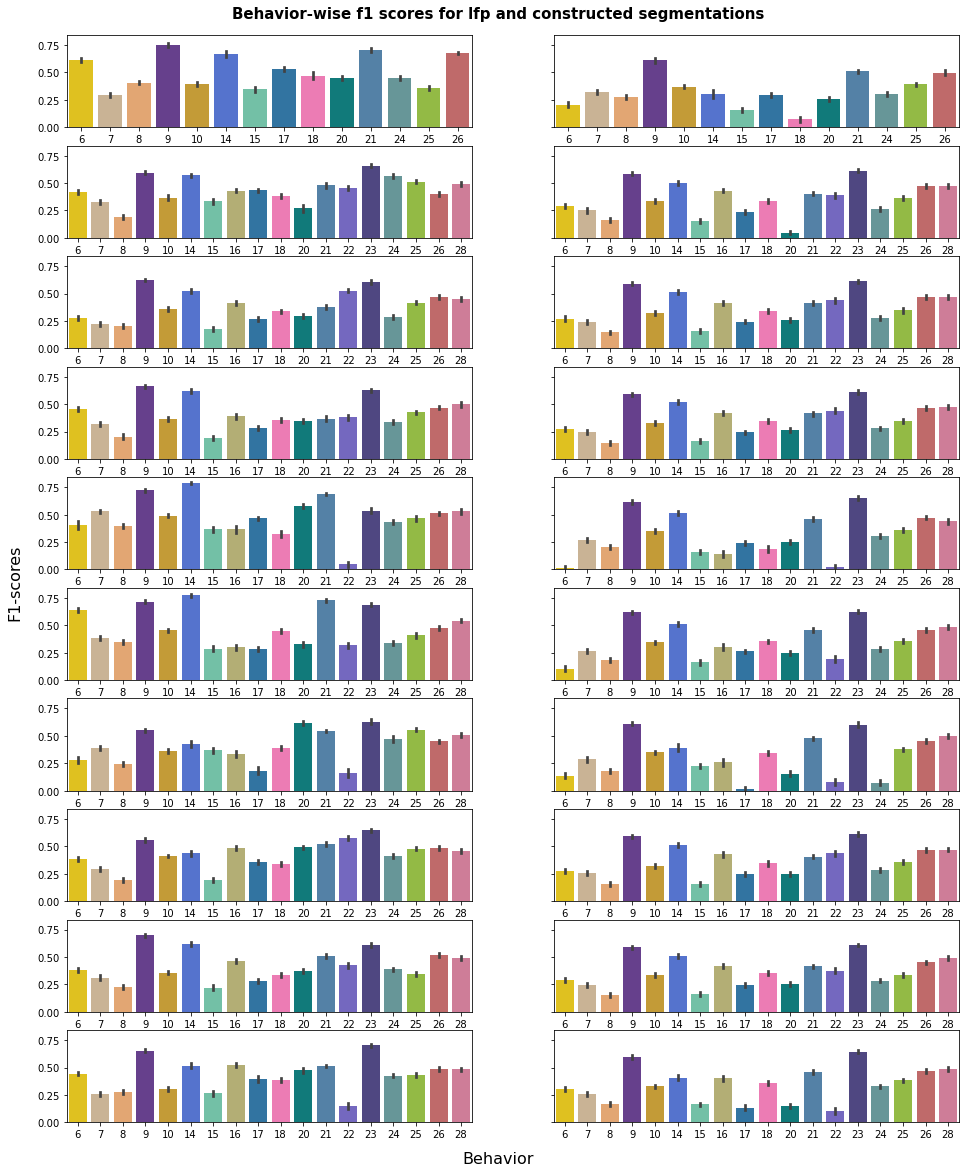

In [104]:
rows = len(np.unique(predict_naive))
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(16, 20), sharey=True)
for i in range(rows):
    state_plt = sns.barplot(data=state_dfs[i], x="behav", y="f1_score", ax=ax[i][0], palette = cmap_all[uiq_y_arr[i]], width=0.6)
    state_plt.set(xlabel=None, ylabel=None)
    struct_plt = sns.barplot(data=struct_dfs[i], x="behav", y="f1_score", ax=ax[i][1], palette = cmap_all[uiq_y_arr[i]], width=0.6)
    struct_plt.set(xlabel=None, ylabel=None)
fig.suptitle('Behavior-wise f1 scores for lfp and constructed segmentations', fontweight='bold', y=0.9, fontsize=15)
fig.text(0.5, 0.1, 'Behavior', ha='center', va='center', fontsize=16)
fig.text(0.08, 0.5, 'F1-scores', ha='center', va='center', rotation='vertical', fontsize=16)